In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving insurance.csv to insurance.csv
User uploaded file "insurance.csv" with length 55628 bytes


In [ ]:
# Import all necessary libraries
import pandas as pd                 # For data manipulation
import numpy as np                  # For numerical computations
import seaborn as sns               # For advanced visualizations
import matplotlib.pyplot as plt     # For basic plotting
import warnings
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression # Example classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.preprocessing import StandardScaler
#from sklearn.datasets import load_iris


# Settings to improve readability
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)




In [ ]:
# Load the dataset
df = pd.read_csv("insurance.csv")  # Replace with your local file path if needed

# Preview first few rows
df.head(25)



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
# Shape of the dataset
print("Total Rows:", df.shape[0])
print("Total Columns:", df.shape[1])

# Check data types and non-null counts
df.info()

# Check summary statistics for numeric columns
df.describe()


Total Rows: 1338
Total Columns: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Check total missing values per column
df.isnull().sum().sort_values(ascending=False)


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
# Handle numeric columns (int/float)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)  # Replaces missing values with median
    print(f"Filled missing values in {col} with median: {median_val}")

# Handle categorical columns (object/string)
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)    # Replaces missing values with most frequent value
    print(f"Filled missing values in {col} with mode: {mode_val}")


Filled missing values in age with median: 39.0
Filled missing values in bmi with median: 30.4
Filled missing values in children with median: 1.0
Filled missing values in charges with median: 9382.033
Filled missing values in sex with mode: male
Filled missing values in smoker with mode: no
Filled missing values in region with mode: southeast


In [ ]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    original_size = df.shape[0]
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    removed = original_size - df.shape[0]
    print(f"{removed} outliers removed from '{col}'")
    return df


In [ ]:
# Save cleaned dataset for later use
df.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved successfully.")


Cleaned dataset saved successfully.


# **Performing EDA and feature selection**

Now that the data is clean, we explore:
- Relationships between features
- How charges changes with sex, bmi, smoker and no.of children
- Visual patterns in the dataset

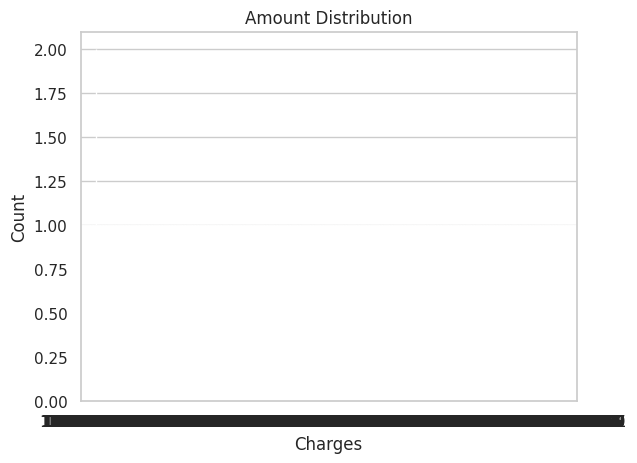

In [ ]:
# Charges
sns.countplot(x='charges', data=df)
plt.title("Amount Distribution")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()


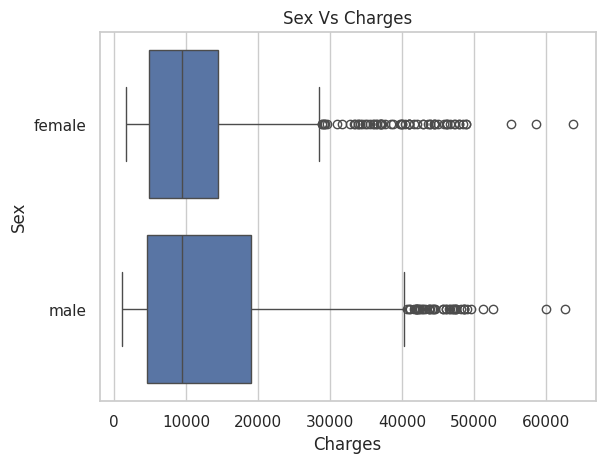

In [ ]:
# Boxplot of sex vs charges
sns.boxplot(x='charges', y='sex', data=df)
plt.title("Sex Vs Charges")
plt.xlabel("Charges")
plt.ylabel("Sex")
plt.show()


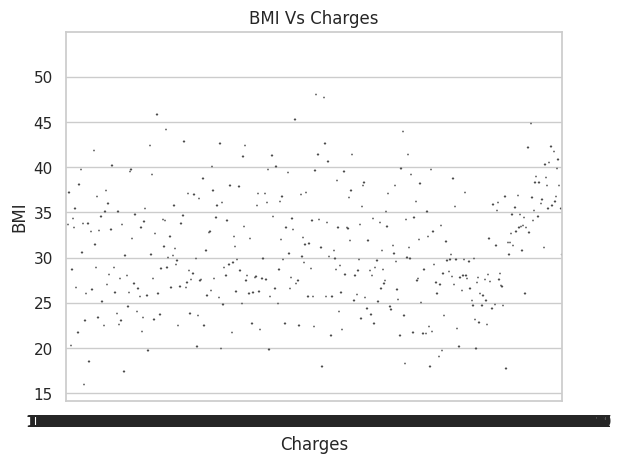

In [ ]:
# Boxplot of bmi vs charges
sns.boxplot(x='charges', y='bmi', data=df)
plt.title("BMI Vs Charges")
plt.xlabel("Charges")
plt.ylabel("BMI")
plt.show()


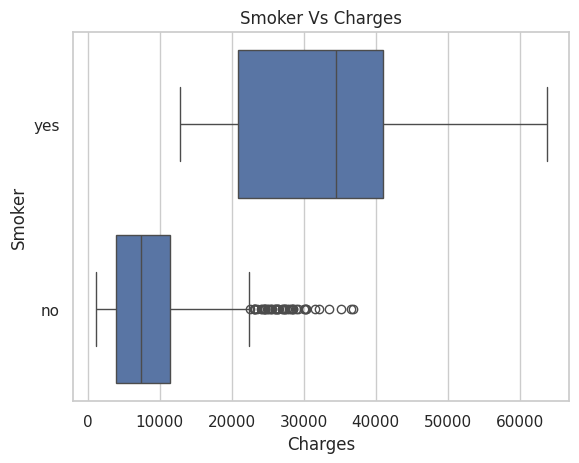

In [ ]:
# Boxplot of smoker vs charges
sns.boxplot(x='charges', y='smoker', data=df)
plt.title("Smoker Vs Charges")
plt.xlabel("Charges")
plt.ylabel("Smoker")
plt.show()


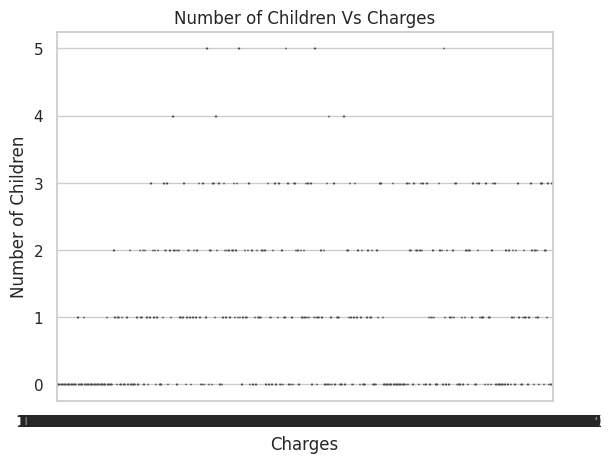

In [ ]:
# Boxplot of no.of children vs charges
sns.boxplot(x='charges', y='children', data=df)
plt.title("Number of Children Vs Charges")
plt.xlabel("Charges")
plt.ylabel("Number of Children")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keep the original dataframe with the target variable
original_df = df.copy()

# Separate features (X) and target (y) before one-hot encoding
X = original_df.drop('charges', axis=1)
y = original_df['charges']

# checking for categorical columns
categ_cols = X.select_dtypes(include='object').columns
#print(categ_cols)

# One-Hot Encoder
from sklearn.preprocessing import OneHotEncoder
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)

numeric_df = X.select_dtypes(include='number')
corr_matrix1 = numeric_df.corr()
# original_data = corr_matrix1 # This variable is not used later, can be removed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:

# Building Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# change classifier to regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# change y_pred = classifier.predict(X_test) to
y_pred = regressor.predict(X_test)

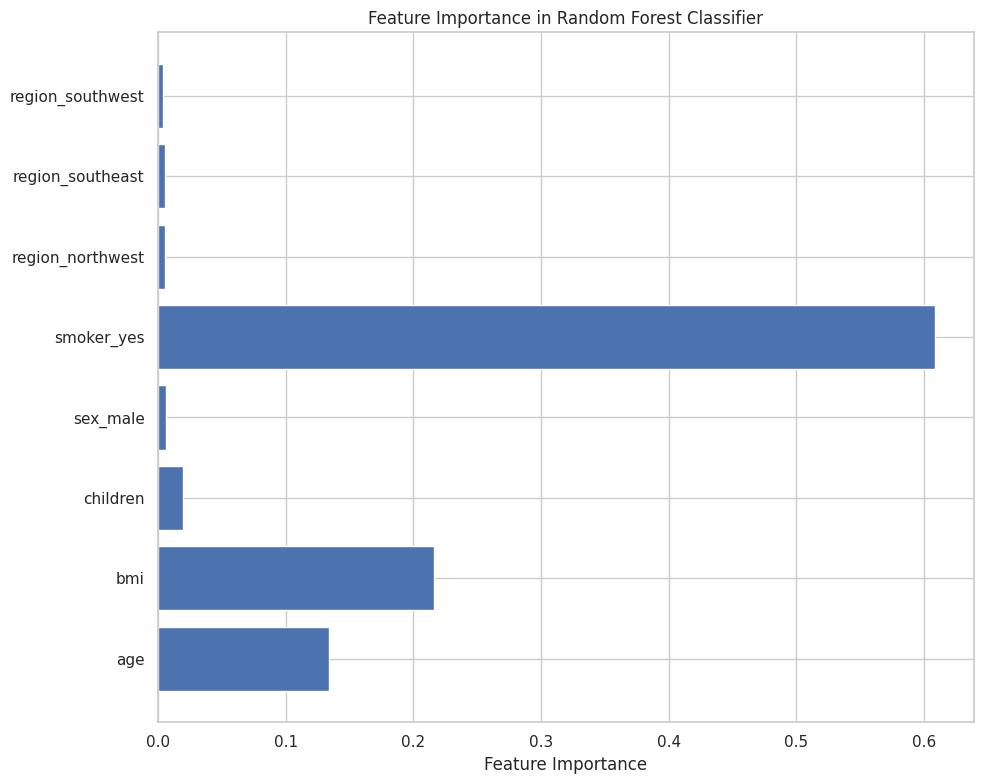

In [ ]:
# Feature importance
feature_importances = regressor.feature_importances_

# Get the feature names from the one-hot encoded DataFrame
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.tight_layout()
plt.show()

# **Training a regression model**

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
# make Predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

NameError: name 'lr' is not defined

# **Improving R^2 from <0.6 to >0.85**